# Model from the Saranya paper

In [8]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

import os

#NN
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics


## Preview images

In [2]:
i = 3
img_1 = cv2.imread(f"banana_dataset_saranya2021/Green/g00{str(i)}.jpg")
img_2 = cv2.imread("banana_dataset_saranya2021/Overripen/v002.jpg")
print("image 1 shape (lines, columns, channels) = ", img_1.shape) 
print("image 2 shape (lines, columns, channels) = ", img_2.shape) 
print("\nimage type: ", type(img_1))

image 1 shape (lines, columns, channels) =  (536, 960, 3)
image 2 shape (lines, columns, channels) =  (540, 960, 3)

image type:  <class 'numpy.ndarray'>


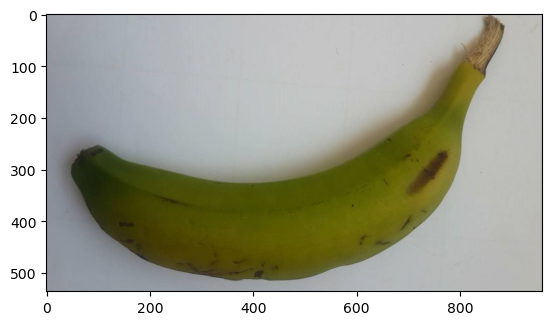

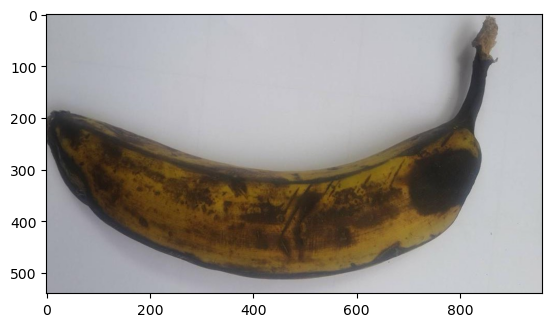

In [3]:
rgb_img_1 = cv2.cvtColor(img_1, cv2.COLOR_BGR2RGB) # BGR to RGB 
rgb_img_2 = cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB) # BGR to RGB 
plt.imshow(rgb_img_1)
#plt.axis('off')
plt.show()

plt.imshow(rgb_img_2)
#plt.axis('off')
plt.show()

## Data Pre-processing

Usando padding com zeros para que todas as imagens tenham a mesma dimensão, porque têm pequenas variações.

Também se poderia ter feito crop ou resize, mas pareceu-me a maneira de perder menos informação

image.shape[0]-->540


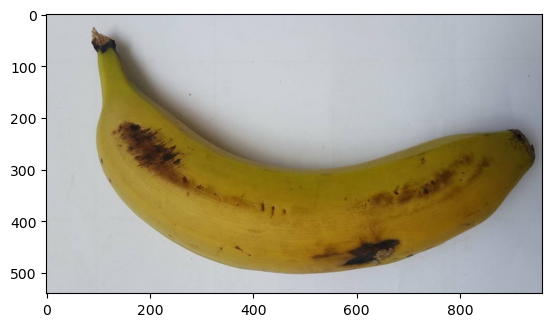

image.shape[1]-->960


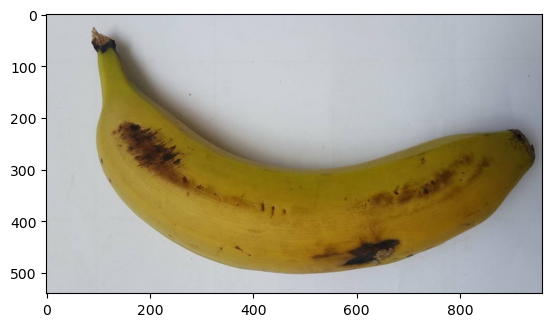

target_size-->(636, 960)


In [22]:
# paths to the image folders of each class
class1_path = "banana_dataset_saranya2021/Green"
class2_path = "banana_dataset_saranya2021/Midripen"
class3_path = "banana_dataset_saranya2021/Overripen"
class4_path = "banana_dataset_saranya2021/Yellowish_Green"

# Define empty lists to store the images and labels
images = []
labels = []

# Loop through each folder and extract the images
for class_path, class_label in [(class1_path, 0), (class2_path, 1), (class3_path, 2), (class4_path, 3)]:
    for image_file in os.listdir(class_path):
        # Load the image and convert to RGB format
        image_path = os.path.join(class_path, image_file)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Add the image and label to the lists
        images.append(image)
        labels.append(class_label)

# Determine the largest image size
max_height = max(image.shape[0] for image in images)
max_width = max(image.shape[1] for image in images)
target_size = (max_height, max_width)

# Define empty list to store the padded images
padded_images = []

# Loop through the images and pad them to match the largest size
for image in images:
    # Check if the image is already the target size
    height, width, _ = image.shape
    if height == max_height and width == max_width:
        padded_image = image
    else:
        # Pad the image to match the target size
        pad_top = (max_height - height) // 2
        pad_bottom = max_height - height - pad_top
        pad_left = (max_width - width) // 2
        pad_right = max_width - width - pad_left
        padded_image = cv2.copyMakeBorder(image, pad_top, pad_bottom, pad_left, pad_right, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    # Append the padded image to the list
    padded_images.append(padded_image)

# Convert the images and labels to NumPy arrays
X = np.array(padded_images)
y = np.array(labels)

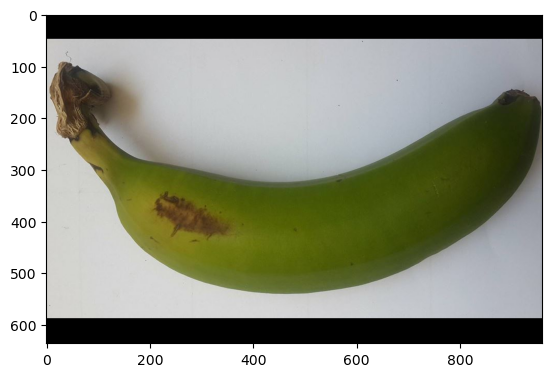

In [ ]:
plt.imshow(X[6])
#plt.axis('off')
plt.show()

In [20]:
for img in images:
    print(img.shape)

(536, 960, 3)
(540, 960, 3)
(536, 960, 3)
(536, 960, 3)
(536, 960, 3)
(536, 960, 3)
(536, 960, 3)
(536, 960, 3)
(536, 960, 3)
(536, 960, 3)
(540, 960, 3)
(536, 960, 3)
(536, 960, 3)
(536, 960, 3)
(536, 960, 3)
(536, 960, 3)
(536, 960, 3)
(536, 960, 3)
(540, 960, 3)
(540, 960, 3)
(536, 960, 3)
(536, 960, 3)
(536, 960, 3)
(536, 960, 3)
(536, 960, 3)
(536, 960, 3)
(540, 960, 3)
(540, 960, 3)
(540, 960, 3)
(540, 960, 3)
(536, 960, 3)
(536, 960, 3)
(536, 960, 3)
(536, 960, 3)
(540, 960, 3)
(540, 960, 3)
(540, 960, 3)
(536, 960, 3)
(540, 960, 3)
(540, 960, 3)
(536, 960, 3)
(540, 960, 3)
(536, 960, 3)
(540, 960, 3)
(540, 960, 3)
(540, 960, 3)
(540, 960, 3)
(540, 960, 3)
(536, 960, 3)
(540, 960, 3)
(540, 960, 3)
(540, 960, 3)
(540, 960, 3)
(540, 960, 3)
(540, 960, 3)
(540, 960, 3)
(540, 960, 3)
(540, 960, 3)
(540, 960, 3)
(540, 960, 3)
(540, 960, 3)
(1072, 1920, 3)
(540, 960, 3)
(540, 960, 3)
(536, 960, 3)
(540, 960, 3)
(540, 960, 3)
(540, 960, 3)
(540, 960, 3)
(536, 960, 3)
(536, 960, 3)
(540

In [5]:
X.shape

(273, 1072, 1920, 3)

In [6]:
y.shape

(273,)

### Spliting the data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle= True)


## CNN

In [ ]:
model = Sequential()

model.add(layers.Conv2D(32, 3, activation = 'relu', padding="same", input_shape = X[0].shape))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, 3, activation = 'relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, 3, activation = 'relu', padding="same"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(units = 512, activation = 'relu'))
model.add(layers.Dense(units = 1, activation = 'sigmoid'))